In [1]:
import torch
from visualizer import CLS_tokens, plot_tokens_category, plot_tokens_continuous
from transformers import ViTForImageClassification, ViTFeatureExtractor

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rk

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/_CL_expression_z64_bs512/model/')
model = ViTForImageClassification.from_pretrained('../outputs/_CL_expression_z64_bs512/model/')

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from dataset import AffectNetDatasetForSupConWithCategoricalValence

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])


dataset = AffectNetDatasetForSupConWithCategoricalValence('../../Affectnet/validation.csv',
                                               '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                               transform1=transform,
                                               transform2=transform)

In [5]:
from tqdm import tqdm

def head_outputs(model, dataset, device):
    features = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            feature = model(img.unsqueeze(0).to(device)).logits
        # print(feature)
        features.append(feature.cpu())
        labels.append(label)
    return torch.stack(features).squeeze(), torch.tensor(labels)

In [6]:
features, labels = head_outputs(model.to(device), dataset, device)
# features, labels = CLS_tokens(model.to(device), dataset, device)

100%|██████████| 4000/4000 [00:45<00:00, 88.76it/s] 


plotting tokens...


4000it [00:10, 385.63it/s]


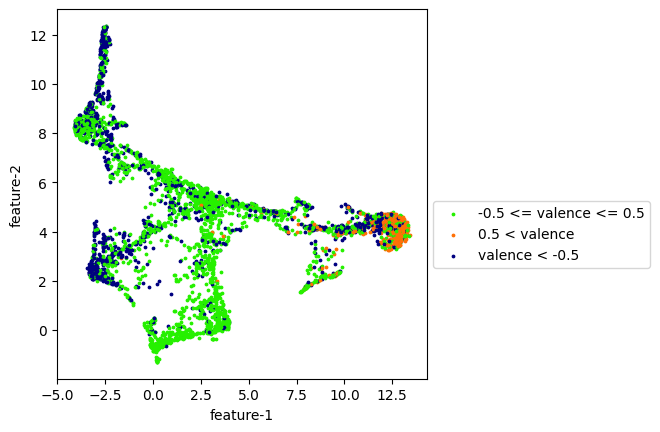

In [7]:
from utils import exclude_id

id2label = {
            0: 'valence < -0.5',
            1: '-0.5 <= valence <= 0.5',
            2: '0.5 < valence',
        }
fig = plot_tokens_category(features, labels, 20, id2label, 0)